In [213]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\skabh\AppData\Local\Temp\ipykernel_40472\1746312659.py:1: SyntaxWarning: invalid escape sequence '\c'
  img = torchvision.io.read_image("images t4\cyber-kitty.jpg")
C:\Users\skabh\AppData\Local\Temp\ipykernel_40472\1746312659.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


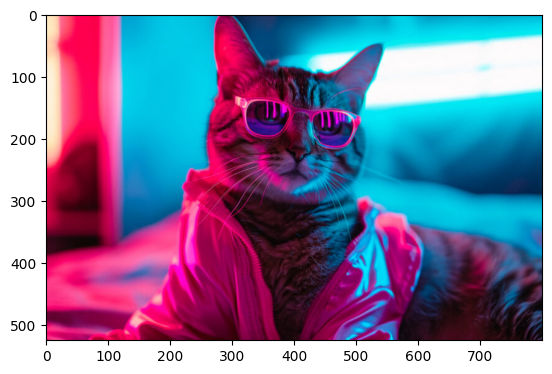

In [214]:
img = torchvision.io.read_image("images t4\cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)
plt.imshow(img.permute(1, 2, 0)/255)

In [215]:
def normalize(img):
    return img/255
def denormalize(img):
    return img*255

In [216]:
def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1 / rmse)
    return rmse.item(), psnr.item()

In [217]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

In [218]:
def plot_images(original, reconstructions, ranks):
    num_reconstructions = len(reconstructions)

    rows = num_reconstructions
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4), constrained_layout=True)
    fig.suptitle("Image Reconstruction", fontsize=22)
    
    for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
        axes[i, 0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 0].set_title("Original Image", fontsize=16)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"Reconstructed Image (rank = {r})", fontsize=16)
        axes[i, 1].axis('off')
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Q. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.


*   Test different values for the low-rank r=[5,10,25,50].
*   Use Gradient Descent to learn the compressed matrices.

In [219]:
def patches_matrix_facorization(crop1,top,left):
    reconstructions = []
    ranks = []
    imgs_with_patches_placed = []
    rmse_rank = []
    psnr_rank = []

    for r in [5, 10, 25, 50]:
        W_red, H_red, loss_red = factorize(crop1[0], r)
        W_green, H_green, loss_green = factorize(crop1[1], r)
        W_blue, H_blue, loss_blue = factorize(crop1[2], r)
        red_reconstructed = torch.mm(W_red, H_red)
        green_reconstructed = torch.mm(W_green, H_green)
        blue_reconstructed = torch.mm(W_blue, H_blue)
        reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
        reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
        reconstructed_img = reconstructed_img.to(torch.uint8)
        rmse_patch, psnr_patch = calculate_metrics(normalize(crop1), normalize(reconstructed_img))

        print("\nMatrix Rank =", r)
        print("The Peak signal to noise ratio is:", psnr_patch)
        print("The Root mean square error is:", rmse_patch)
        print()
        rmse_rank.append(rmse_patch)
        psnr_rank.append(psnr_patch)

        reconstructed_img = reconstructed_img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        n_img = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

        reconstructions.append(reconstructed_img)

        n_img[top:top+50, left:left+50] = reconstructed_img
        
        imgs_with_patches_placed.append(n_img)

        ranks.append(r)

    return reconstructions, ranks, imgs_with_patches_placed, rmse_rank, psnr_rank


In [220]:
def plot_images_with_patches(crop1, reconstructions, ranks):
    fig, axes = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
    fig.suptitle("Compressed Images", fontsize=22)

    for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
        axes[i, 0].imshow(crop1.permute(1, 2, 0).numpy().astype(np.uint8))
        axes[i, 0].set_title("Original Image", fontsize=10)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed)
        axes[i, 1].set_title(f"Rank = {r}", fontsize=10)
        axes[i, 1].axis('off')

    plt.show()

In [221]:
def plot_original_vs_reconstructed(img, imgs_with_patches_placed, ranks,top,left):
    fig, axes = plt.subplots(4, 2, figsize=(20, 30))
    for i in range(4):
        axes[i, 0].imshow(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 0].add_patch(plt.Rectangle((left, top), 50, 50, fill=False, edgecolor='green', lw=2))
        axes[i, 0].set_title("Original Image", fontsize=10)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 1].add_patch(plt.Rectangle((left, top), 50, 50, fill=False, edgecolor='green', lw=2))
        axes[i, 1].set_title("Original Image", fontsize=10)
        axes[i, 1].axis('off')
    for i, j in enumerate(imgs_with_patches_placed):
        axes[i, 1].imshow(j)
        axes[i, 1].set_title(f"Rank = {ranks[i]}", fontsize=10)
        axes[i, 1].axis('off')

    plt.show()

In [222]:
def plot_metrics(ranks, rmse_rank, psnr_rank):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(ranks, rmse_rank, color = "red", marker = "o")
    axes[0].set_title("RMSE vs Rank")
    axes[0].set_xlabel("Rank")
    axes[0].set_ylabel("RMSE")
    axes[0].grid()

    axes[1].plot(ranks, psnr_rank, color = "blue", marker = "o")
    axes[1].set_title("PSNR vs Rank")
    axes[1].set_xlabel("Rank")
    axes[1].set_ylabel("PSNR")
    axes[1].grid()

Trying with three different types of patches to see how color density affects the model.

**Crop 1(Multiple colors in the patch)**

(-0.5, 49.5, 49.5, -0.5)

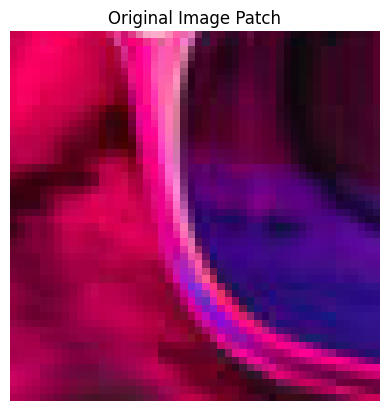

In [223]:
crop1 = torchvision.transforms.functional.crop(img, 150, 300, 50, 50)

plt.imshow(crop1.permute(1, 2, 0).numpy().astype(np.uint8))
plt.title("Original Image Patch")
plt.axis('off')

In [224]:
reconstructions, ranks, imgs_with_patches_placed, rmse_rank, psnr_rank = patches_matrix_facorization(crop1,150,300)


Matrix Rank = 5
The Peak signal to noise ratio is: 20.748519897460938
The Root mean square error is: 0.09174323081970215


Matrix Rank = 10
The Peak signal to noise ratio is: 27.856454849243164
The Root mean square error is: 0.04047410935163498


Matrix Rank = 25
The Peak signal to noise ratio is: 47.50172424316406
The Root mean square error is: 0.004216127097606659


Matrix Rank = 50
The Peak signal to noise ratio is: 52.542118072509766
The Root mean square error is: 0.002359902486205101



Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.

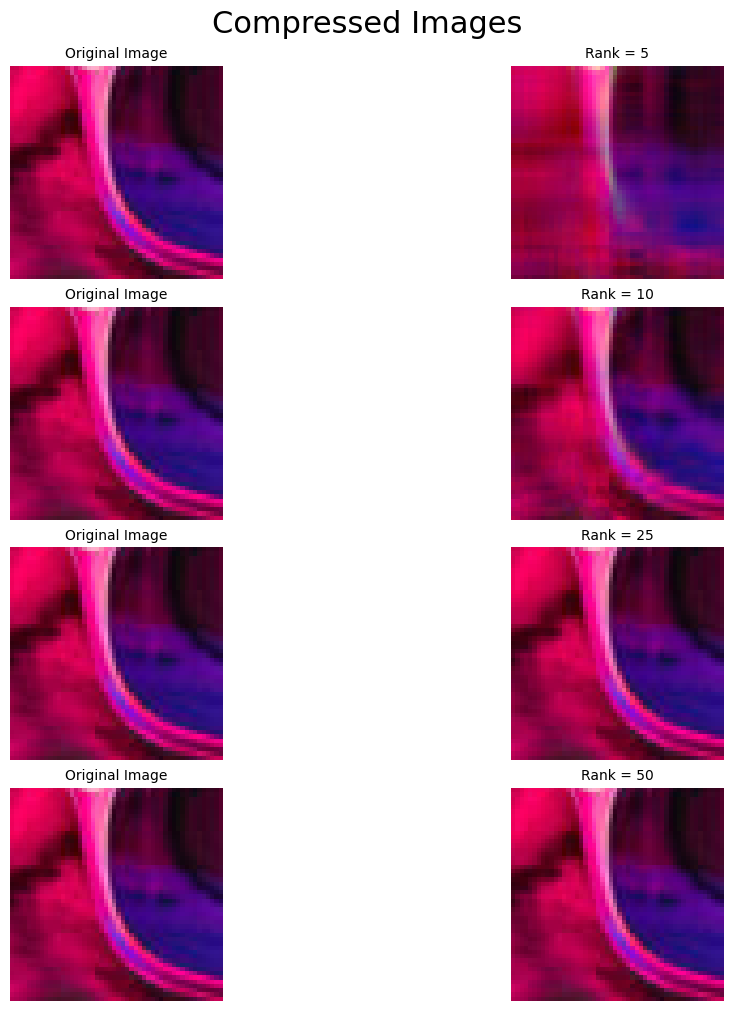

In [225]:
plot_images_with_patches(crop1, reconstructions, ranks)

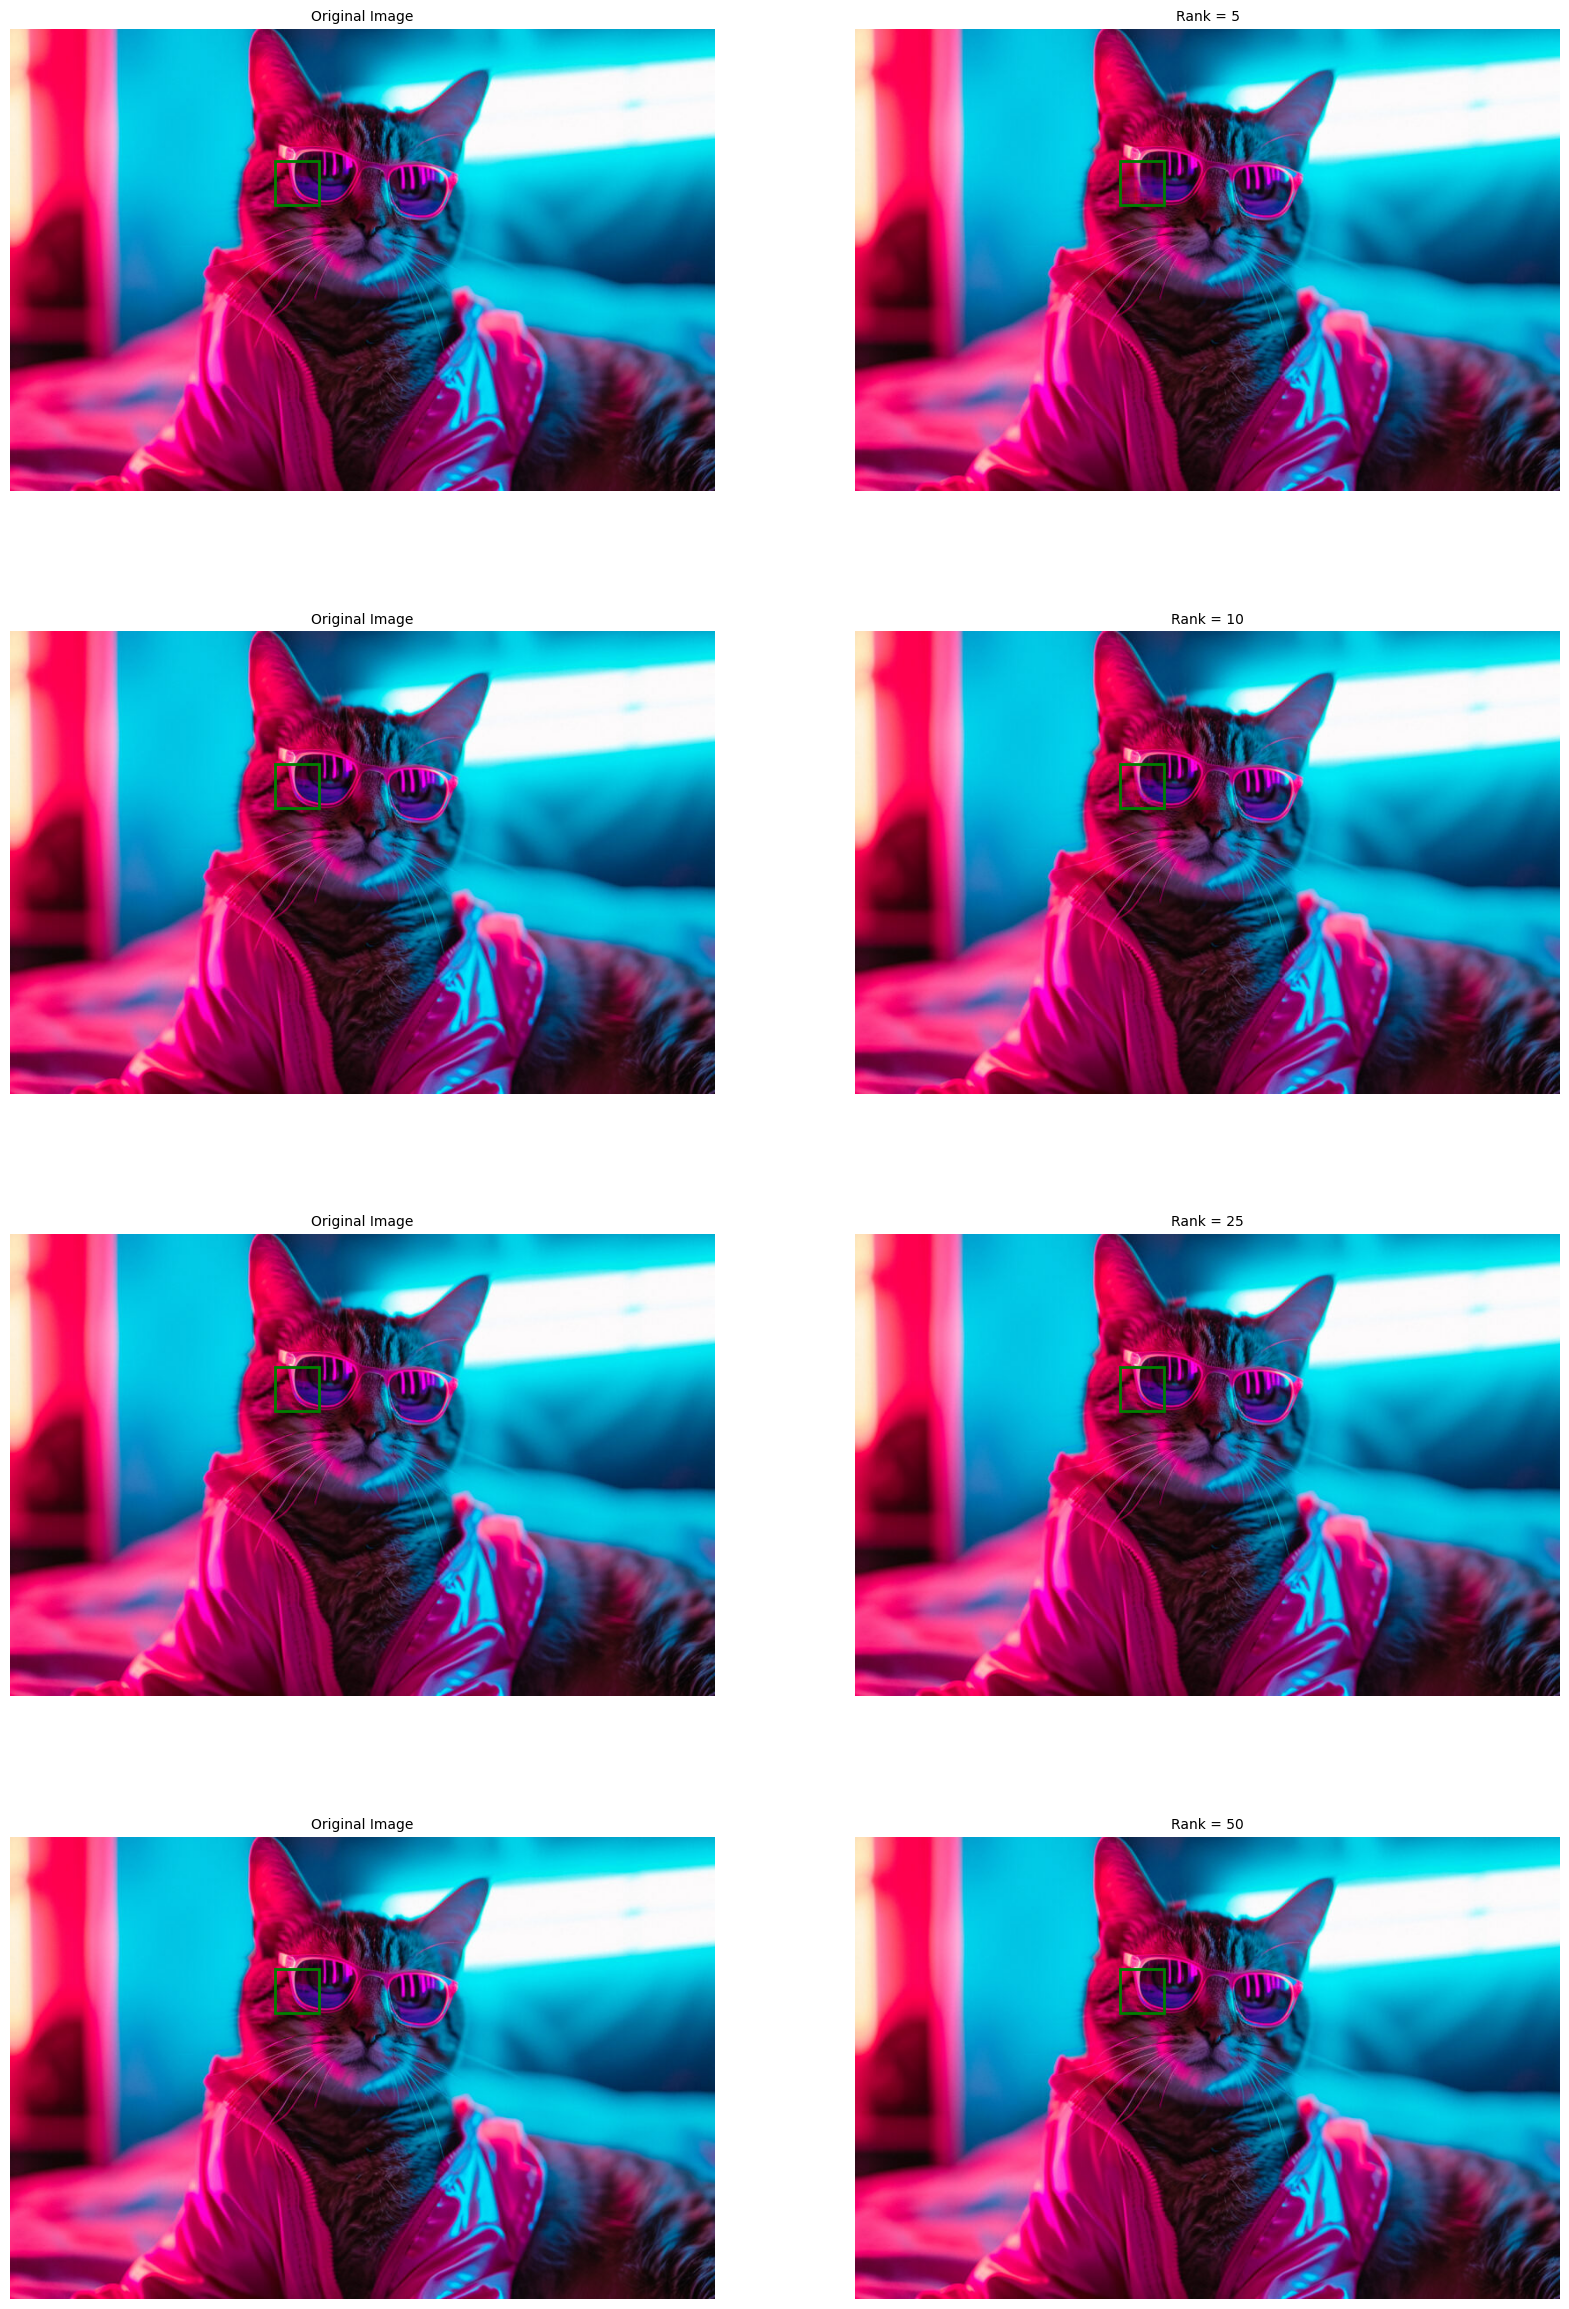

In [226]:
plot_original_vs_reconstructed(img, imgs_with_patches_placed, ranks,150,300)

**Crop 2 (Single Color in the patch)**

(-0.5, 49.5, 49.5, -0.5)

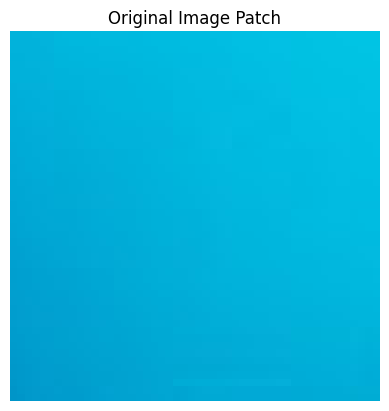

In [227]:
crop2 = torchvision.transforms.functional.crop(img, 200, 170 , 50, 50)
plt.imshow(crop2.permute(1, 2, 0).numpy().astype(np.uint8))
plt.title("Original Image Patch")
plt.axis('off')

In [228]:
reconstructions, ranks, imgs_with_patches_placed, rmse_rank, psnr_rank = patches_matrix_facorization(crop2,200,170)


Matrix Rank = 5
The Peak signal to noise ratio is: 47.5344123840332
The Root mean square error is: 0.00420029042288661


Matrix Rank = 10
The Peak signal to noise ratio is: 50.40563201904297
The Root mean square error is: 0.003017994575202465


Matrix Rank = 25
The Peak signal to noise ratio is: 51.76927185058594
The Root mean square error is: 0.0025795057881623507


Matrix Rank = 50
The Peak signal to noise ratio is: 51.95660400390625
The Root mean square error is: 0.0025244669523090124



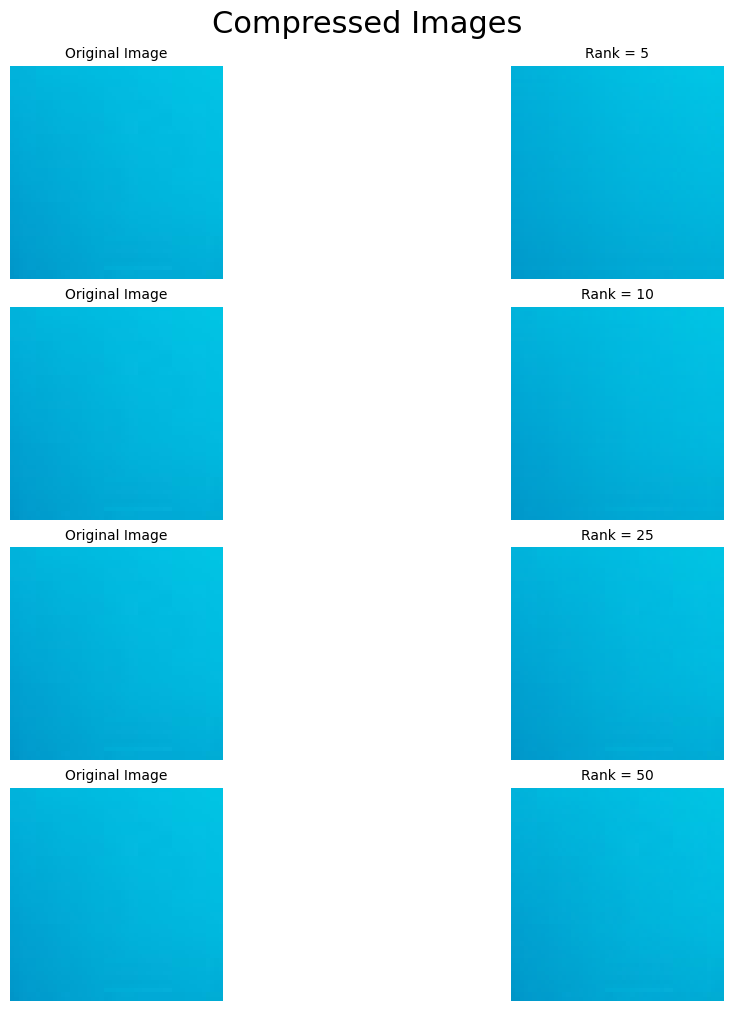

In [229]:
plot_images_with_patches(crop2, reconstructions, ranks)

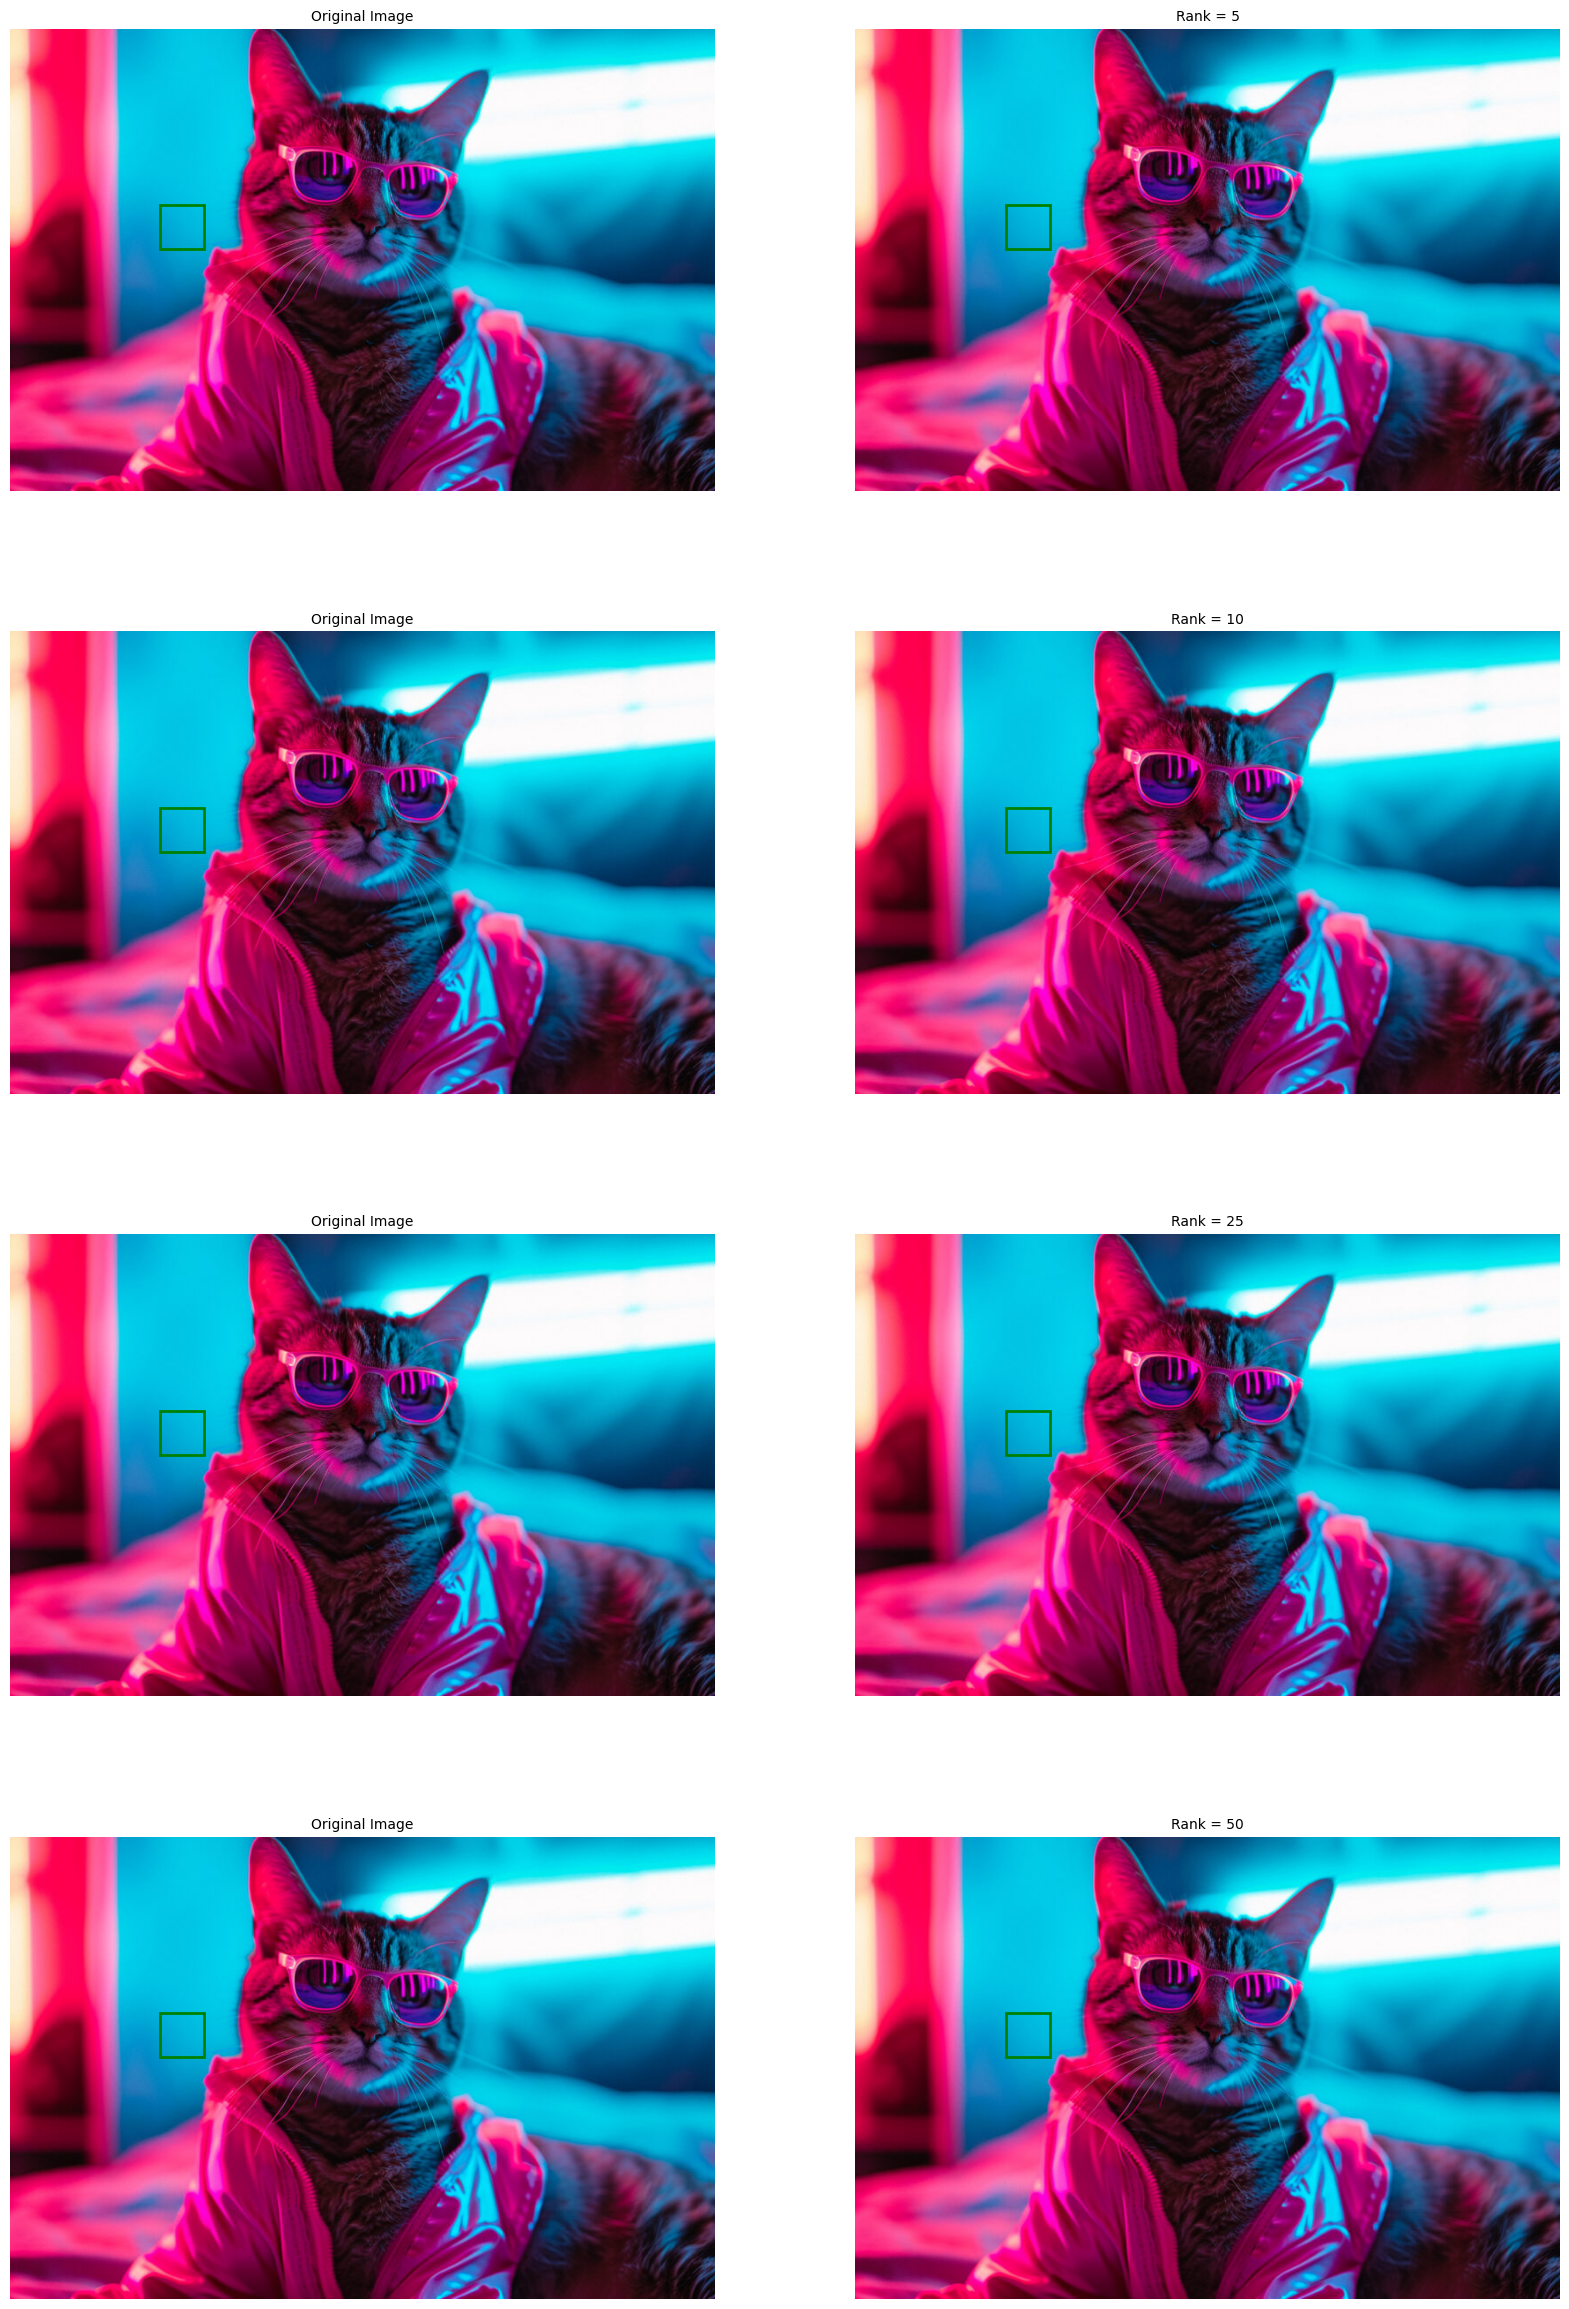

In [230]:
plot_original_vs_reconstructed(img, imgs_with_patches_placed,ranks,200,170)

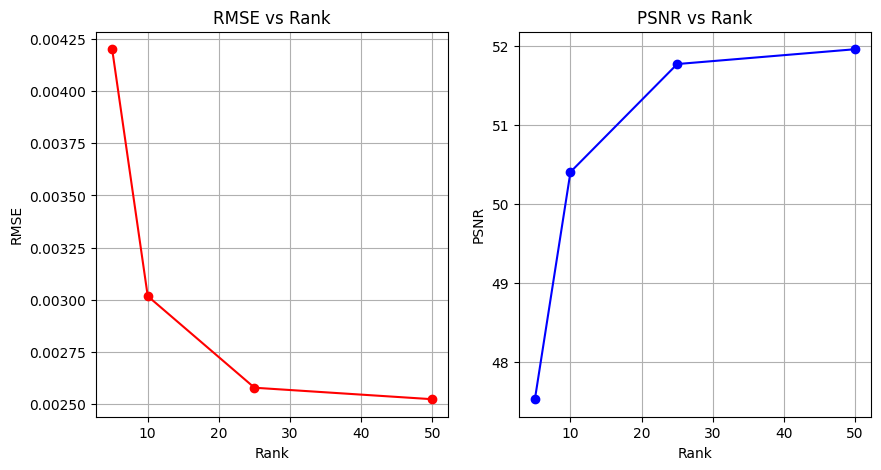

In [231]:
plot_metrics(ranks, rmse_rank, psnr_rank)

**Crop 3 (2 Colors in the patch)**

(-0.5, 49.5, 49.5, -0.5)

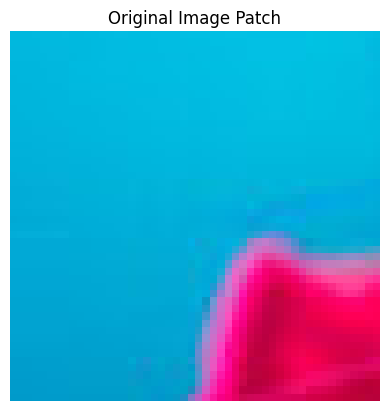

In [232]:
crop3 = torchvision.transforms.functional.crop(img, 220, 200, 50, 50)
plt.imshow(crop3.permute(1, 2, 0).numpy().astype(np.uint8))
plt.title("Original Image Patch")
plt.axis('off')

In [234]:
reconstructions, ranks, imgs_with_patches_placed, rmse_rank, psnr_rank = patches_matrix_facorization(crop3, 220, 200)


Matrix Rank = 5
The Peak signal to noise ratio is: 24.444664001464844
The Root mean square error is: 0.05994691699743271


Matrix Rank = 10
The Peak signal to noise ratio is: 38.96577453613281
The Root mean square error is: 0.01126448530703783


Matrix Rank = 25
The Peak signal to noise ratio is: 51.252540588378906
The Root mean square error is: 0.002737618051469326


Matrix Rank = 50
The Peak signal to noise ratio is: 51.264442443847656
The Root mean square error is: 0.0027338704094290733



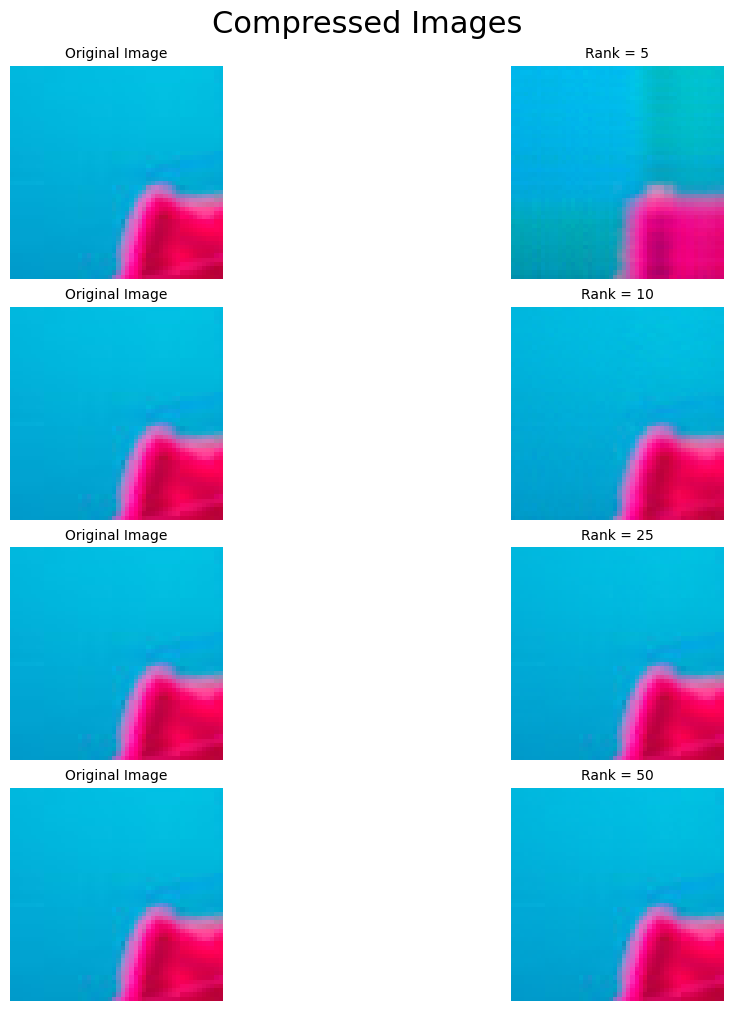

In [235]:
plot_images_with_patches(crop3, reconstructions, ranks)

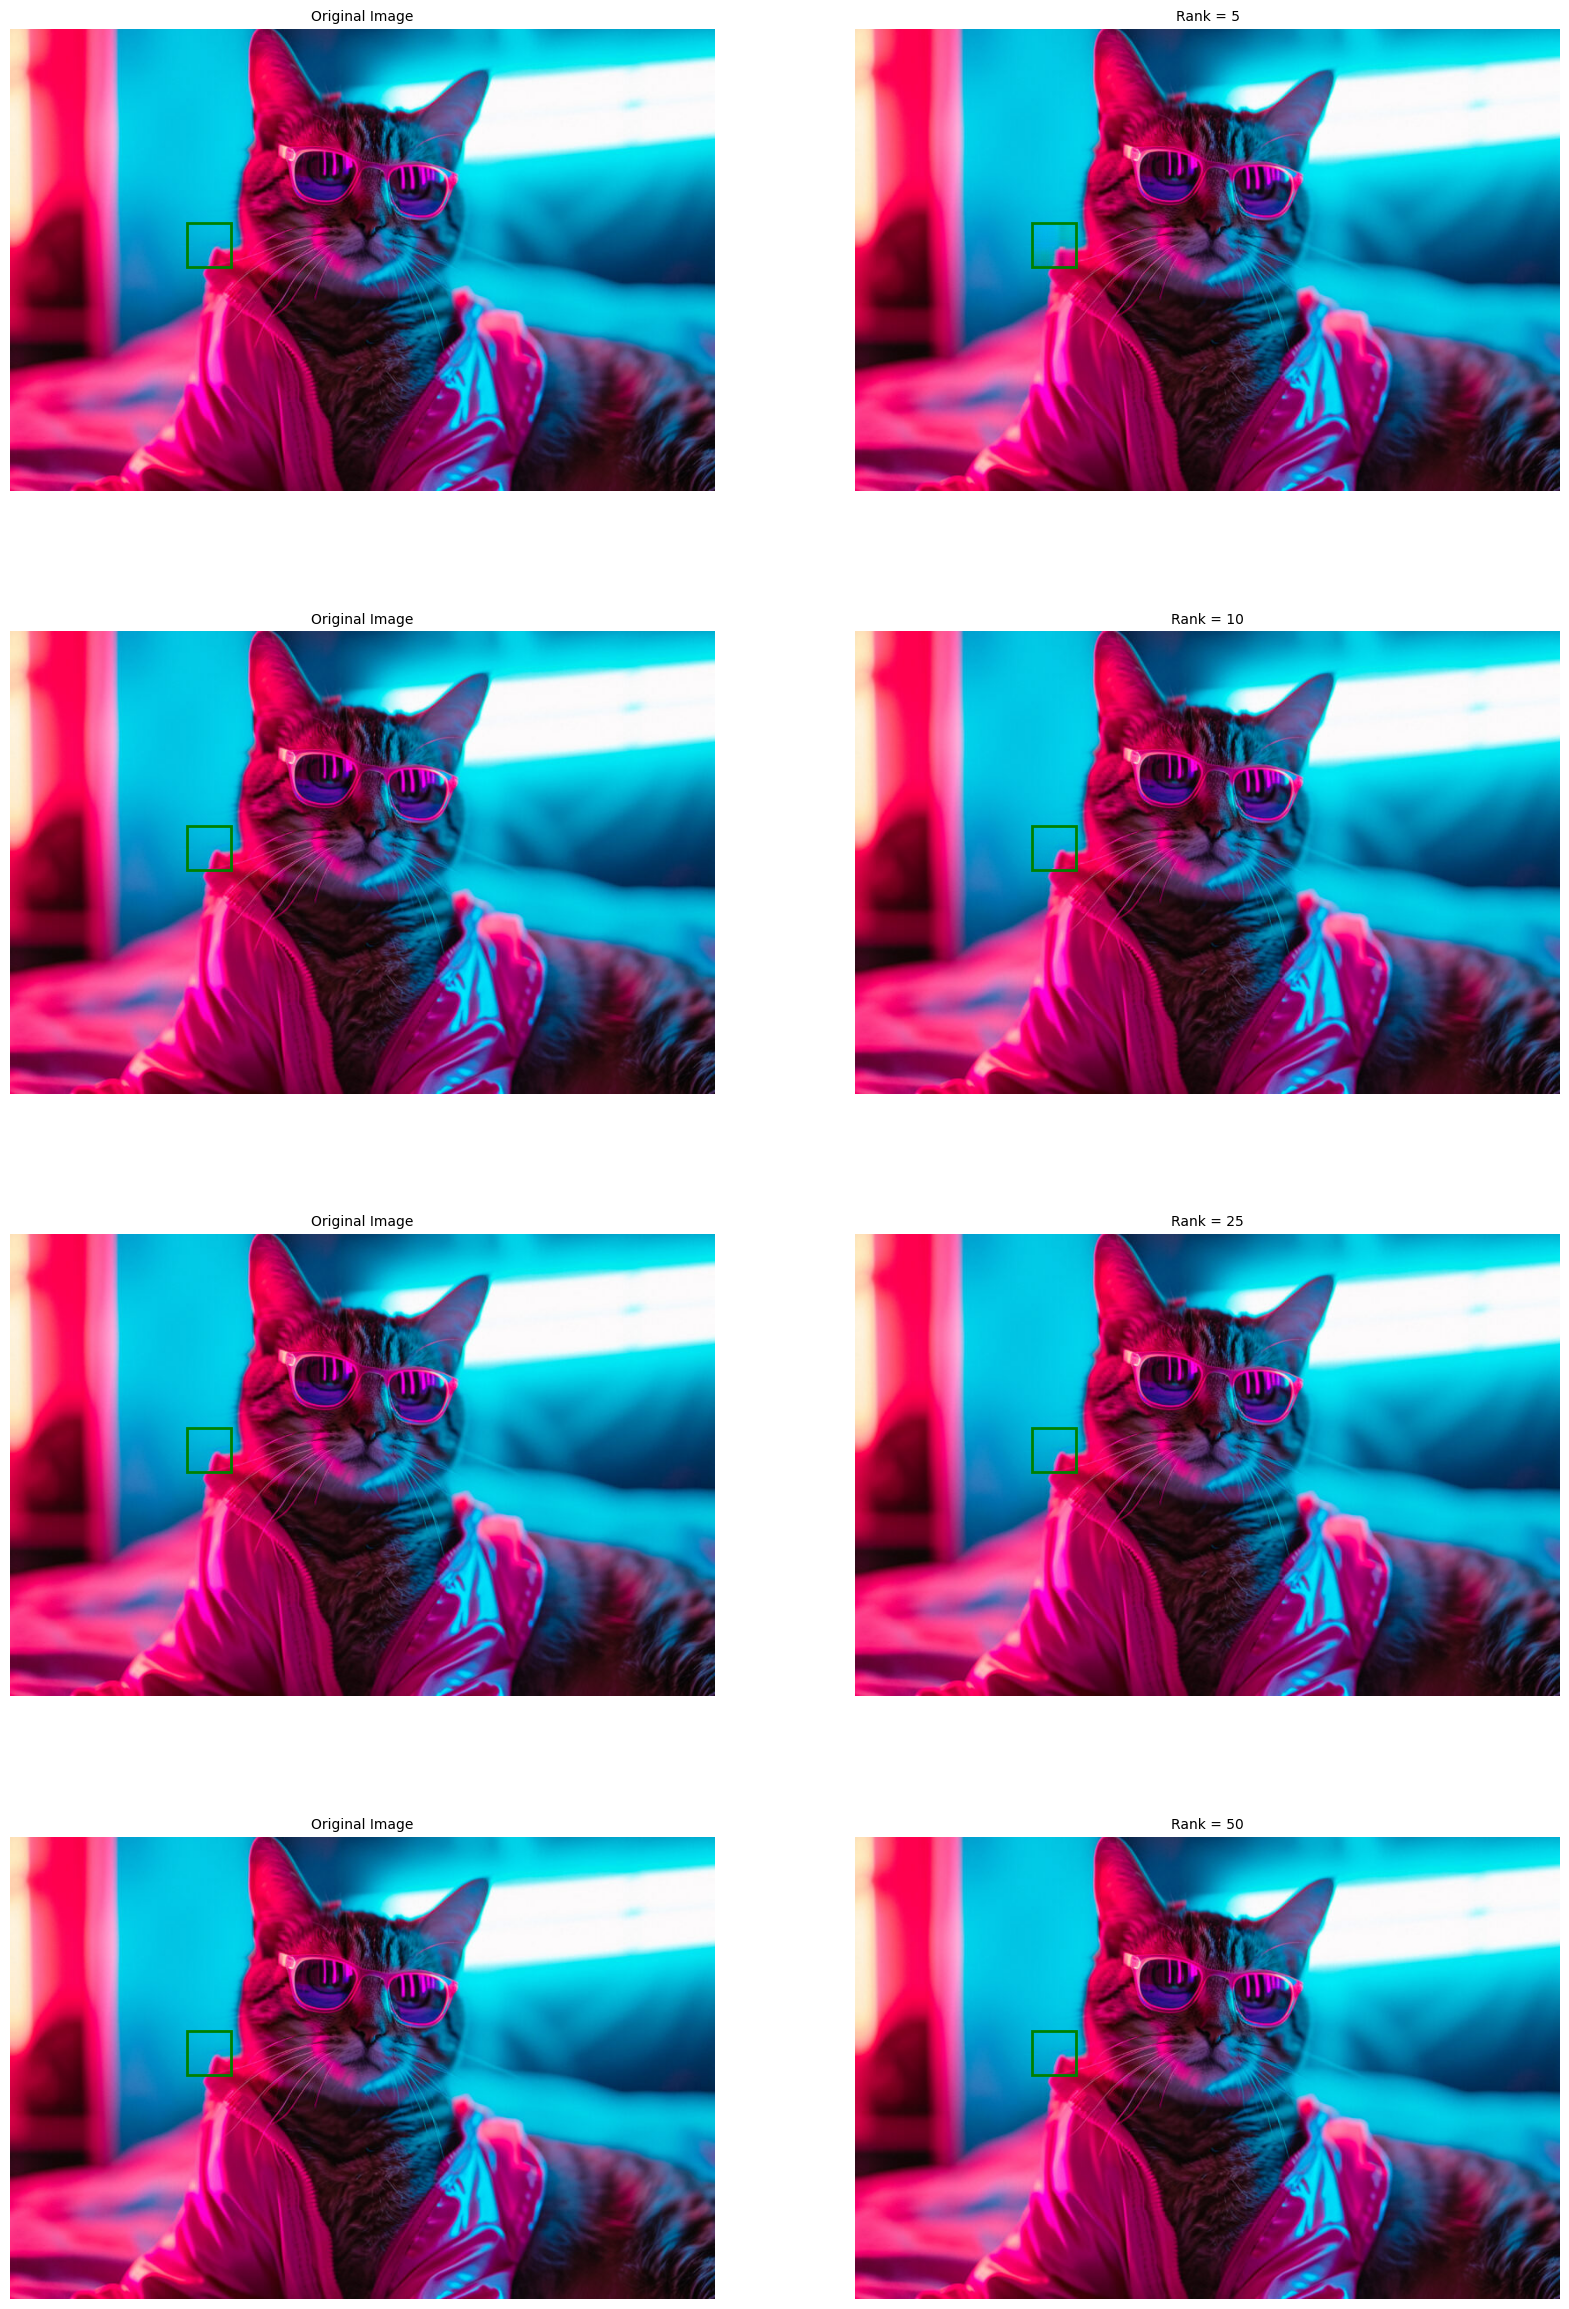

In [236]:
plot_original_vs_reconstructed(img, imgs_with_patches_placed, ranks,220,200)

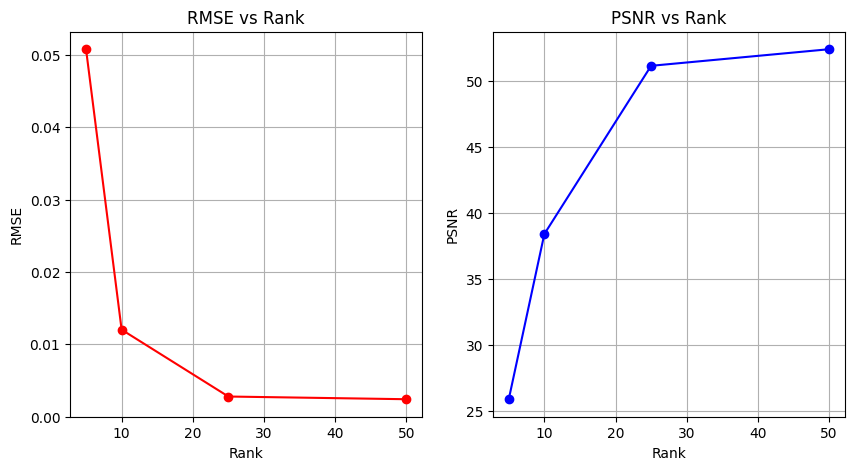

In [212]:
plot_metrics(ranks, rmse_rank, psnr_rank)